In [548]:
import pandas as pd
import numpy as np
df = pd.read_csv("train.csv")
df = df[df["SalePrice"]<480000] ### outlier removal
df.reset_index(inplace=True, drop=True)

/var/folders/9n/1c29yz2x20n8pslry6jflgw00000gn/T/ipykernel_38822/2507348960.py:7: FutureWarning: The provided callable <function mean at 0x103749440> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg = df.groupby(var1)[var2].aggregate(np.mean)
/var/folders/9n/1c29yz2x20n8pslry6jflgw00000gn/T/ipykernel_38822/2507348960.py:8: FutureWarning: The provided callable <function std at 0x103749580> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  std = df.groupby(var1)[var2].aggregate(np.std)


<BarContainer object of 10 artists>

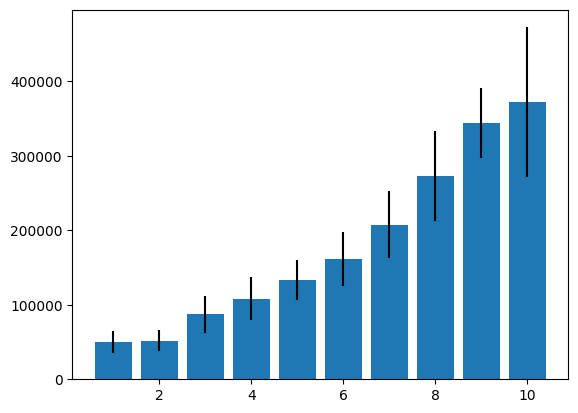

In [549]:
# exploratory analysis

from matplotlib import pyplot as plt
var1 = "OverallQual"
var2 = "SalePrice"

avg = df.groupby(var1)[var2].aggregate(np.mean)
std = df.groupby(var1)[var2].aggregate(np.std)

plt.bar(avg.index, avg.values, yerr=std)

In [550]:
## Defining custom error calculaation for model comparison

def mse(y1, y2):
    return np.mean(np.abs(y1 - y2) / 10000)

In [551]:
## Applying simple imputers for imputing missing values, except Lot Frontage

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import joblib

df2 = df.copy(deep=True)

df2.drop(["PoolQC", "Alley", "Id", "MiscFeature"], axis=1, inplace=True) # Dropping non relevant columns

# Year Built is the best estimator for Garage Year Built
index_impute = df["GarageYrBlt"].isna()
impute_values = df.loc[index_impute, "YearBuilt"]
df2.loc[index_impute, "GarageYrBlt"] = impute_values

# Variables to identify different types of paramters
variable_type = pd.read_excel("variable category.xlsx")
var = variable_type["variable"]
type = variable_type["type"]

numerical = [i for i, j in zip(var, type) if j=="N"]
numerical.remove("LotFrontage") # removing and adding to pass through becasue LF will be predicted later
numerical.remove("GarageYrBlt") # removing because GB is already been imputed
categorical = [i for i, j in zip(var, type) if j=="C"]
ordinal = [i for i, j in zip(var, type) if j=="O"]
pass_through = ["LotFrontage", "MiscVal", "GarageYrBlt"] # MiscVal will be added directly to final prediction

numerical_imputer = SimpleImputer(strategy='mean')     # Mean imputation for numerical
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Missing')  # Fill "Missing" for categorical
ordinal_imputer = SimpleImputer(strategy='median')

preprocessor = ColumnTransformer([
                ('num', numerical_imputer, numerical),
                ('cat', categorical_imputer, categorical),
                ('ord', ordinal_imputer, ordinal),
                ("pt", "passthrough", pass_through)
                ]) 

# Apply transformations
df_imputed = preprocessor.fit_transform(df2)

# Convert back to DataFrame with column names
df_imputed = pd.DataFrame(df_imputed, columns=numerical + categorical + ordinal + pass_through)


In [552]:
from joblib import dump, load
dump(preprocessor, "simple_imputers.joblib")

['simple_imputers.joblib']

#### Building model for Predcting Lot Frontage missing values

In [553]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

cols = ["MSSubClass", "MSZoning", "LotFrontage", "LotArea", "Street", "LotShape", "LandContour"] # using these six factors for predcting LF value
df_frontage = df_imputed[cols]
df_frontage_train = df_frontage[df_frontage["LotFrontage"].notna()] # selecting rows with LF value for model training

X = df_frontage_train.drop("LotFrontage", axis=1)
y = df_frontage_train["LotFrontage"].to_numpy().astype(float)

numerical = ["LotArea"]
categorical = X.columns.to_list()
categorical.remove("LotArea")

## Encoder for factors
preprocessor2 = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical),
    ("scalar", StandardScaler(), numerical)
])

X_processed = preprocessor2.fit_transform(X).toarray()

categorical_features = preprocessor2.named_transformers_["onehot"].get_feature_names_out(categorical)
numerical_features = numerical  # Original names for numerical columns
total_features = list(categorical_features) + numerical_features

df_processed = pd.DataFrame(X_processed, columns=total_features) # encoded factors

In [554]:
dump(preprocessor2, "lot_frontage_transformer.joblib")

['lot_frontage_transformer.joblib']

In [555]:
# variable selection using Lasso Regression
X_train, X_test, y_train, y_test = train_test_split(df_processed, y, test_size=0.01, random_state= 42, shuffle=True)

lf = LassoCV(alphas = np.logspace(-3, 1, 50), cv=5, random_state=42)

lf.fit(X_train, np.log(y_train))

coef = list(lf.coef_)

sig_var = [i for i, j in zip(total_features, list(lf.coef_)) if j!=0] # non-zero variables selected by Lasso

## training Random Forest model with only significant variables
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

X_train_tree = X_train[sig_var]
X_test_tree = X_test[sig_var]

lf_tree = RandomForestRegressor(random_state=42)

grid = {
    "n_estimators" : [100, 200, 300],
    'max_depth': [None, 10 , 20],
    "min_samples_split": [2, 5, 10]
}

search = GridSearchCV(estimator=lf_tree, param_grid=grid, cv=5, scoring="neg_mean_squared_error")

search.fit(X_train_tree, y_train)

lf_tree_best = search.best_estimator_

yhat = lf_tree_best.predict(X_test_tree)

"""plt.scatter(yhat, y_test)
plt.xlim(0, 350)
plt.ylim(0, 350)"""

# imputing LF value using the model

index_impute = df_imputed["LotFrontage"].isna()

X_impute = df_imputed[index_impute]

X_short = X_impute[cols]

X_processed_short = preprocessor2.transform(X_short).toarray()

df_processed_impute = pd.DataFrame(X_processed_short, columns=total_features)

df_processed_impute = df_processed_impute[sig_var]

y_pred = lf_tree_best.predict(df_processed_impute)

df_complete = df_imputed.copy(deep=True)

df_complete.loc[index_impute, "LotFrontage"] = y_pred

df_complete.reset_index(drop=True)

df_complete["SalePrice"] = df["SalePrice"] # final Data with no missing values

In [556]:
# saving both the model and the significant variables

joblib.dump(lf_tree_best, "imputation.joblib")

df_sig_var = pd.DataFrame(data=sig_var, columns=["sig_var"])
df_sig_var.to_excel("sig_var_impute.xlsx")

#### Model for predicting Sale Price

In [557]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

## Encoder for encoding and scaling all the factors

variable_type = pd.read_excel("variable category.xlsx")

var = variable_type["variable"]
type = variable_type["type"]

numerical = [i for i, j in zip(var, type) if j=="N"]
categorical = [i for i, j in zip(var, type) if j=="C"]
ordinal = [i for i, j in zip(var, type) if j=="O"]
pass_through = [i for i, j in zip(var, type) if j=="PT"]

df_complete2 = df_complete.copy(deep=True)

X = df_complete2.drop("SalePrice", axis=1)
y = df_complete2["SalePrice"].to_numpy()

y = np.log(y) # take log to make it more normally distributed
mean = np.mean(y)
std = np.std(y)

y = (y-mean)/std # scaling the response variable

preprocessor3 = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical),
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal),
    ("scalar", StandardScaler(), numerical),
    ("passthrough", "passthrough", pass_through) # only Misc Val is Pass through.
])

X_processed = preprocessor3.fit_transform(X).toarray()

categorical_features = preprocessor3.named_transformers_["onehot"].get_feature_names_out(categorical)
ordinal_features = preprocessor3.named_transformers_["oe"].get_feature_names_out(ordinal)
numerical_features = numerical  # Original names for numerical columns
pass_through_features = pass_through
all_features = list(categorical_features) + list(ordinal_features) + numerical_features + pass_through_features

df_processed = pd.DataFrame(X_processed, columns=all_features) # final dataframe with all the factors properly encoded or scaled

In [558]:
# save the encoder model
from joblib import dump
dump(preprocessor3, "sale_price_transformer.joblib")

['sale_price_transformer.joblib']

In [559]:
### Elastic Net Model training
from sklearn.linear_model import ElasticNetCV

X_train, X_test, y_train, y_test = train_test_split(df_processed, y, test_size=0.01, random_state=10, shuffle=True)

extra_value_train = X_train["MiscVal"]
X_train = X_train.drop("MiscVal", axis=1)

extra_value_test = X_test["MiscVal"]
X_test = X_test.drop("MiscVal", axis=1)

# lf1 = LassoCV(alphas = np.logspace(-5, 1, 10), cv=10, random_state=42)

lf1 = ElasticNetCV(alphas=np.logspace(-5, 1, 10), 
                   l1_ratio=np.linspace(0.1, 1.0, 10),  # l1_ratio controls the mix of Lasso and Ridge
                   cv=5, 
                   random_state=42)

lf1.fit(X_train, y_train)

# back transform and add misc value
yhat_test = (lf1.predict(X_test)*std) + mean # unscale
yhat_test = np.exp(yhat_test) + extra_value_test # take exp and add misc val
y_test = y_test*std + mean
y_test = np.exp(y_test)

yhat_train = (lf1.predict(X_train)*std) + mean
yhat_train = np.exp(yhat_train) + extra_value_train
y_train = y_train*std + mean
y_train = np.exp(y_train)

y_lasso_test = yhat_test

print("Train error: ", mse(yhat_train, y_train))
print("Test error: ", mse(yhat_test, y_test))

/Users/a14702/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/Desktop/new_env/new_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.71355036980227, tolerance: 0.11567574604532879
  model = cd_fast.enet_coordinate_descent_gram(
/Users/a14702/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/Desktop/new_env/new_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.582407182628288, tolerance: 0.11567574604532879
  model = cd_fast.enet_coordinate_descent_gram(
/Users/a14702/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/Desktop/new_env/new_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. Yo

Train error:  1.378048958866362
Test error:  1.8561128572008134


/Users/a14702/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/Desktop/new_env/new_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8418909984373784, tolerance: 0.11690744789248407
  model = cd_fast.enet_coordinate_descent_gram(


In [560]:
# save the lasso model
from joblib import dump
dump(lf1, "model_elastic_net.joblib")

['model_elastic_net.joblib']

In [561]:
### Random Forest Regressor model training with just signifcant variables identified by Lasso

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

y_train = (y_train-mean)/std
y_test = (y_test-mean)/std

coef = list(lf1.coef_)
sig_var = [i for i, j in zip(all_features, coef) if j!=0] # non-zero, aka, signifcant variables

X_train_tree = X_train[sig_var]
X_test_tree = X_test[sig_var]

model_rf = RandomForestRegressor(random_state=42)

# hyperparameter tuning
grid = {
    "n_estimators" : [100, 150, 200],
    'max_depth': [3, 4, 5],
    "min_samples_split": [15, 20, 30]
}

search = GridSearchCV(estimator=model_rf, param_grid=grid, cv=5, scoring="neg_mean_squared_error")

search.fit(X_train_tree, y_train)

model_rf_best = search.best_estimator_

yhat_test = model_rf_best.predict(X_test_tree)*std + mean
yhat_test = yhat_test + extra_value_test
y_test = y_test*std + mean

yhat_train = (model_rf_best.predict(X_train_tree)*std) + mean
yhat_train = yhat_train + extra_value_train
y_train = y_train*std + mean

print("Train error: ", mse(yhat_train, y_train))
print("Test error: ", mse(yhat_test, y_test))

y_rf_test = yhat_test

# plt.scatter(yhat, y_test)
# min_val = min(yhat.min(), y_test.min())
# max_val = max(yhat.max(), y_test.max())
# plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")


Train error:  1.6576264769375493
Test error:  2.192965732609522


In [562]:
# save RF model
from joblib import dump
dump(model_rf_best, "model_random_forest.joblib")

['model_random_forest.joblib']

In [563]:
"""### XG boost model training with just signifcant variables identified by Lasso

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error as mse

y_train = (y_train-mean)/std
y_test = (y_test-mean)/std

coef = list(lf1.coef_)
sig_var = [i for i, j in zip(all_features, coef) if j!=0]

X_train_tree = X_train[sig_var]
X_test_tree = X_test[sig_var]

# Initialize the XGBoost Regressor
model_xgb = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42)

# Fit the model
model_xgb.fit(X_train_tree, y_train)

yhat_test = model_xgb.predict(X_test_tree)*std + mean
yhat_test = yhat_test + extra_value_test
y_test = y_test*std + mean

yhat_train = model_xgb.predict(X_train_tree)*std + mean
yhat_train = yhat_train + extra_value_train
y_train = y_train*std + mean

print("Train error: ", mse(yhat_train, y_train))
print("Test error: ", mse(yhat_test, y_test))

y_xgb_test = yhat_test

# plt.scatter(yhat, y_test)
# min_val = min(yhat.min(), y_test.min())
# max_val = max(yhat.max(), y_test.max())
# plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")"""

'### XG boost model training with just signifcant variables identified by Lasso\n\nfrom xgboost import XGBRegressor\nfrom sklearn.model_selection import GridSearchCV\n# from sklearn.metrics import mean_squared_error as mse\n\ny_train = (y_train-mean)/std\ny_test = (y_test-mean)/std\n\ncoef = list(lf1.coef_)\nsig_var = [i for i, j in zip(all_features, coef) if j!=0]\n\nX_train_tree = X_train[sig_var]\nX_test_tree = X_test[sig_var]\n\n# Initialize the XGBoost Regressor\nmodel_xgb = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42)\n\n# Fit the model\nmodel_xgb.fit(X_train_tree, y_train)\n\nyhat_test = model_xgb.predict(X_test_tree)*std + mean\nyhat_test = yhat_test + extra_value_test\ny_test = y_test*std + mean\n\nyhat_train = model_xgb.predict(X_train_tree)*std + mean\nyhat_train = yhat_train + extra_value_train\ny_train = y_train*std + mean\n\nprint("Train error: ", mse(yhat_train, y_train))\nprint("Test error: ", mse(yhat_test, y_test))\n\ny_xgb_test = yh

In [564]:
"""## Save the XGB model
from joblib import dump
dump(model_xgb, "model_xgb.joblib")"""

'## Save the XGB model\nfrom joblib import dump\ndump(model_xgb, "model_xgb.joblib")'

In [565]:
from sklearn.ensemble import GradientBoostingRegressor

y_train = (y_train-mean)/std
y_test = (y_test-mean)/std

coef = list(lf1.coef_)
sig_var = [i for i, j in zip(all_features, coef) if j!=0]

X_train_tree = X_train[sig_var]
X_test_tree = X_test[sig_var]

model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4)
model_gb.fit(X_train_tree, y_train)

yhat_test = model_gb.predict(X_test_tree)*std + mean
yhat_test = yhat_test + extra_value_test
y_test = y_test*std + mean

yhat_train = model_gb.predict(X_train_tree)*std + mean
yhat_train = yhat_train + extra_value_train
y_train = y_train*std + mean

print("Train error: ", mse(yhat_train, y_train))
print("Test error: ", mse(yhat_test, y_test))

y_gb_test = yhat_test

Train error:  0.8189894414012964
Test error:  1.1251674153127773


In [566]:
## Save the XGB model
from joblib import dump
dump(model_gb, "model_gb.joblib")

['model_gb.joblib']

In [567]:
## Use the weightage avg from all the models to predcted the final value
yhat_test = (0.5*y_lasso_test + 0.0*y_rf_test + 0.5*y_gb_test)
print(mse(yhat_test, y_test))

1.3757987579319737


Text(0, 0.5, 'True Value')

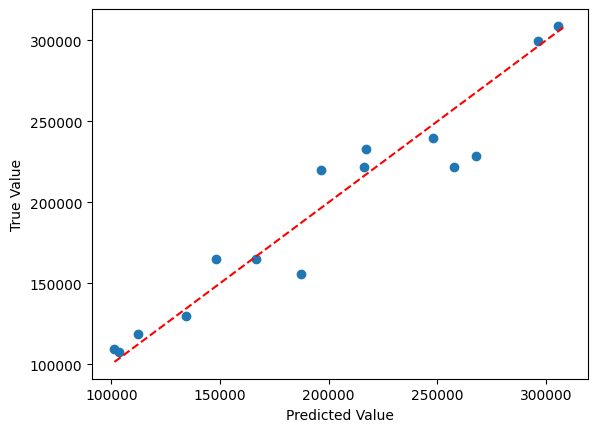

In [568]:
plt.scatter(yhat_test, y_test)
min_val = min(yhat_test.min(), y_test.min())
max_val = max(yhat_test.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

#### Additional model and analysis that was not used for prediction

inf


/Users/a14702/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/Desktop/new_env/new_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


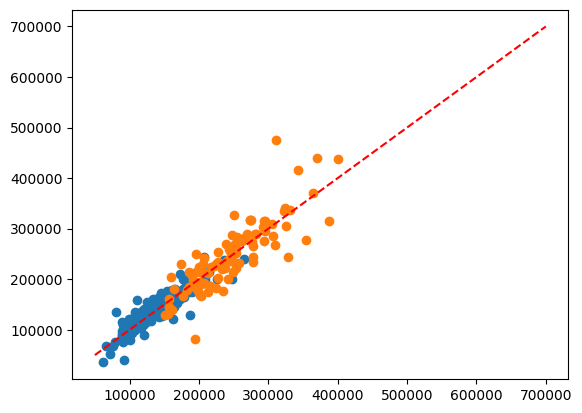

In [570]:
### Multimodels- two models
from sklearn.decomposition import PCA

X = df_complete.drop("SalePrice", axis=1)
y = df_complete["SalePrice"]

preprocessor3 = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first"), categorical),
    ("oe", OrdinalEncoder(), ordinal),
    ("scalar", StandardScaler(), numerical),
    ("passthrough", "passthrough", pass_through)
])

X_processed = preprocessor3.fit_transform(X).toarray()

categorical_features = preprocessor3.named_transformers_["onehot"].get_feature_names_out(categorical)
ordinal_features = preprocessor3.named_transformers_["oe"].get_feature_names_out(ordinal)
numerical_features = numerical  # Original names for numerical columns
pass_through_features = pass_through
all_features = list(categorical_features) + list(ordinal_features) + numerical_features + pass_through_features

df_processed = pd.DataFrame(X_processed, columns=all_features)

df_processed["SalePrice"] = y.tolist()

data_train, data_test = train_test_split(df_processed, test_size=0.2, random_state= 42, shuffle=True)

index1 = data_train["OverallQual"]<=5.5
index2 = data_train["OverallQual"]>5.5

d1 = data_train[index1]
d2 = data_train[index2]

X1, y1 = d1.drop("SalePrice", axis=1), d1["SalePrice"]
X1 = X1.drop("MiscVal", axis=1)
lf1 = LassoCV(alphas = np.logspace(-3, 1, 50), cv=5, random_state=42)
lf1.fit(X1, np.log(y1))

X2, y2 = d2.drop("SalePrice", axis=1), d2["SalePrice"]
X2 = X2.drop("MiscVal", axis=1)

pca = PCA(n_components=0.9)  # Retain 95% of the variance
X2 = pca.fit_transform(X2)

model_rf = RandomForestRegressor(random_state=42)

grid = {
    "n_estimators" : [100, 200, 300],
    'max_depth': [None, 5 , 10],
    "min_samples_split": [15, 20, 30]
}

search = GridSearchCV(estimator=model_rf, param_grid=grid, cv=5, scoring="neg_mean_squared_error")

search.fit(X2, y2)

lf2 = search.best_estimator_

index1 = data_test["OverallQual"]<=5.5
index2 = data_test["OverallQual"]>5.5

d1 = data_test[index1]
d2 = data_test[index2]

X1, y1 = d1.drop("SalePrice", axis=1), d1["SalePrice"]
X2, y2 = d2.drop("SalePrice", axis=1), d2["SalePrice"]

misc_val1 = X1["MiscVal"]
misc_val2 = X2["MiscVal"]

X1 = X1.drop("MiscVal", axis=1)
X2 = X2.drop("MiscVal", axis=1)
X2 = pca.transform(X2)

yh1 = np.exp(lf1.predict(X1)) + misc_val1
yh2 = lf2.predict(X2) + misc_val2

plt.scatter(yh1, y1)
plt.scatter(yh2, y2)
plt.plot([50000, 700000], [50000, 700000], 'r--', label="y = x")

ms = mse(np.exp(yh1), y1) + mse(np.exp(yh2), y2)
print(ms)

In [571]:
ms = mse(yh1, y1) + mse(yh2, y2)
print(ms)

3.710241521506185


In [572]:
from joblib import dump, load
dump(lf1, "two_model_lasso.joblib")

['two_model_lasso.joblib']